# ML Model Experimentation and Selection
In this notebook, we will test out three different models (XGBoost vs Random Forest vs NN). We will compare the results of these models based on MSE, MAE, R^2 evaluation metrices to find the best model for predicting housing prices.

In [61]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [62]:
# Import dataset 
private_data = "../datasets/cleaned/cleaned_private.csv"

df = pd.read_csv(private_data, quotechar='"', escapechar='\\', thousands=',')

### XGBoost Model
Note that *Distance from MRT station* and *1Km to Top Primary Schools* have not been included yet

In [64]:
# Function to remove outliers for a numeric column
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Preprocess data: Extract 'Sale Month-Year' from 'Sale Date'
df['Sale Month-Year'] = pd.to_datetime(df['Sale Date']).dt.to_period('M').astype(str)

# Apply outlier removal to numeric columns only
for col in ['Price', 'Area (SQFT)', 'Remaining Lease Years']:
    df = remove_outliers_iqr(df, col)

# Reset index after filtering
df.reset_index(drop=True, inplace=True)

# Select relevant columns
features = ['Area (SQFT)', 'Remaining Lease Years', 'Property Type', 
            'Type of Sale', 'Floor Level', 'Sale Month-Year']
target = 'Price'

# Encode categorical features
df_encoded = df[features + [target]].copy()
categorical_cols = ['Property Type', 'Type of Sale', 'Floor Level', 'Sale Month-Year']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save if needed later

# Split into features and target
X = df_encoded[features]
y = df_encoded[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

# Train XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=40)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


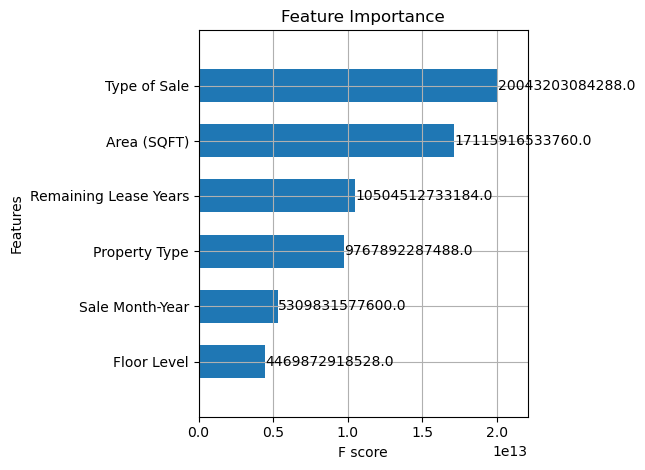

In [65]:
# Feature Importance Plot (which features XGBoost found most useful during training)
xgb.plot_importance(model, importance_type='gain', height=0.6)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

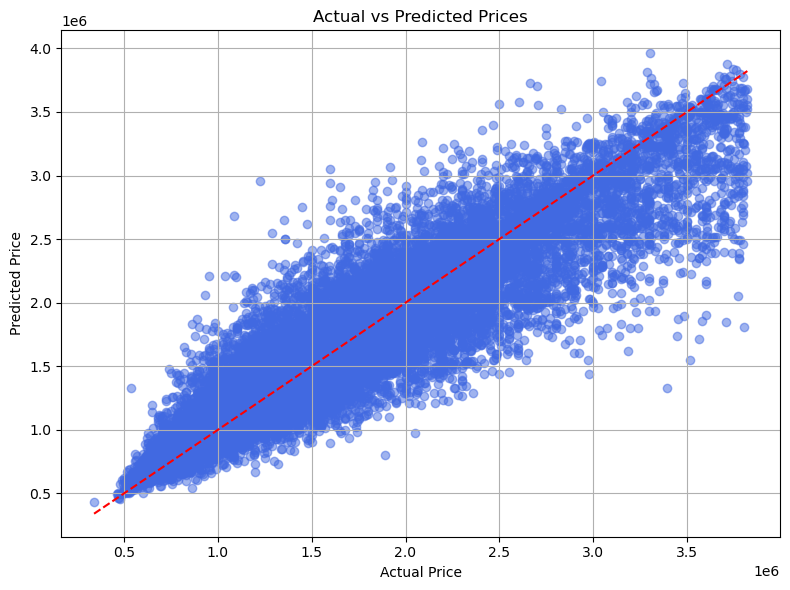

In [66]:
# Scatter Plot of Actual vs Predicted Prices (how close predictions are to the actual values)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
# Evaluate XGBoost model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error (MSE): 67517517964.07
Mean Absolute Error (MAE): 174544.41
R^2 Score: 0.8453
